In [52]:
%%capture
%matplotlib inline

# Downloads and imports

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install ogb
!git clone https://github.com/m-k-S/neural-mechanics-geometric.git

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.norm import GraphNorm, PairNorm, MessageNorm, DiffGroupNorm, BatchNorm

from ogb.graphproppred import PygGraphPropPredDataset
from torch.utils.data import random_split
from torch_geometric.datasets import TUDataset, QM9, GNNBenchmarkDataset
from torch_geometric.loader import DataLoader

import networkx as nx
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [63]:
# Hacky but convenient
# Re-run upon code changes to the utilities code (for cleanliness/conciseness)
!cd neural-mechanics-geometric/ && git pull

import sys
sys.path.append('./neural-mechanics-geometric')

from importlib import reload
import order_parameters
reload(order_parameters)
import data_utils
reload(data_utils)

from order_parameters import Activs_prober, Conv_prober
from data_utils import initial_order_params, save_order_params, clear_order_params

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/m-k-S/neural-mechanics-geometric
   97722e0..f3e0cc5  master     -> origin/master
Updating 97722e0..f3e0cc5
Fast-forward
 order_parameters.py | 5 +++--
 1 file changed, 3 insertions(+), 2 deletions(-)


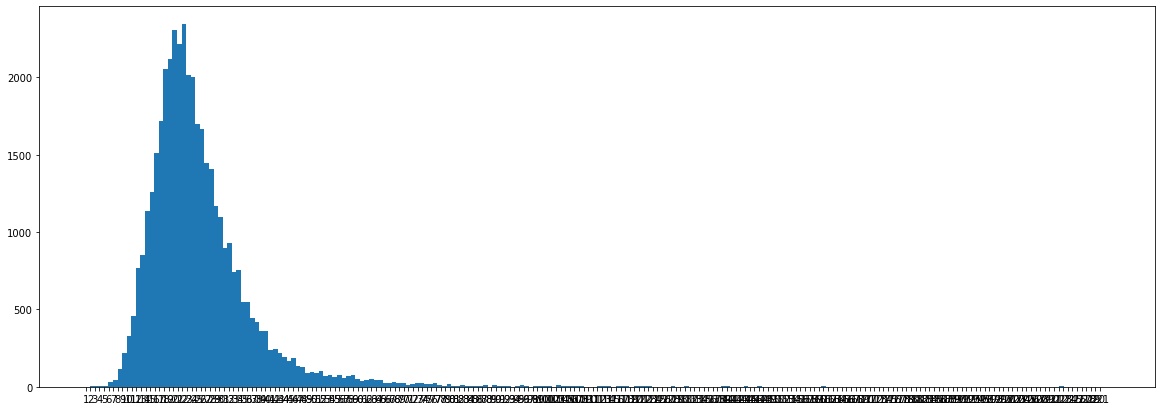


Dataset: [Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 40], edge_attr=[40, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 40], edge_attr=[40, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 9], y=[1, 1], num_nodes=18), Data(edge_index=[2, 38], edge

In [54]:
### Dataset

# Experiment Parameters
batch_size = 128
restrict = True # restrict the dataset to only graphs with a fixed_nodes number of nodes
fixed_nodes = 18
dataset = 'MOLHIV'
task = 'regression' if dataset == 'QM9' else 'classification'

if dataset == 'QM9':
    dataset = QM9(root='data/QM9')
elif dataset == 'PPA':
    dataset = PygGraphPropPredDataset(name = 'ogbg-ppa')
elif dataset == 'MOLHIV':
    dataset = PygGraphPropPredDataset(name = 'ogbg-molhiv')
elif dataset == 'PROTEINS':
    dataset = TUDataset(root='data/TUDataset', name='PROTEINS_full', use_node_attr=True)

# Restrict dataset to only graphs with a fixed number of nodes
if restrict:

    restricted_dataset = []
    num_nodes = []
    for d in dataset:
        num_nodes.append(len(d.x))
        if len(d.x) == fixed_nodes:
            restricted_dataset.append(d)

    plt.figure(figsize=(20, 7))
    plt.hist(num_nodes, bins=max(num_nodes))
    plt.xticks(np.arange(1, max(num_nodes), step=1))
    plt.show()

    dataset = restricted_dataset

try:
    split_idx = dataset.get_idx_split() 
    train_loader = DataLoader(dataset[split_idx["train"]], batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset[split_idx["test"]], batch_size=batch_size, shuffle=False)
except AttributeError:
    train_dataset, test_dataset = random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2) + 1])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
try:
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')
except:
    pass

# print(f'Dataset balance: {dataset.data.y.flatten().bincount()[0] / len(dataset.data.y)}')

In [60]:
class GCN(torch.nn.Module):
    def __init__(
            self, 
            hidden_channels, 
            num_input_features, 
            num_layers=3, 
            task='classification', 
            norm=None, 
            norm_args=None):
        # Normalization layers need specific kwargs:
        # BatchNorm: in_channels (int)
        # GraphNorm: in_channels (int)
        # PairNorm: scale (int)
        # DiffGroupNorm: in_channels (int), groups (int)
        super(GCN, self).__init__()
        self.num_layers = num_layers

        norm_map = {'BatchNorm': BatchNorm, 'GraphNorm': GraphNorm, 'PairNorm': PairNorm, 'DiffGroupNorm': DiffGroupNorm}
        self.norm = norm

        self.conv_layers = nn.ModuleList()
        self.conv_probes = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        self.activ_probes = nn.ModuleList()

        for l in range(num_layers):
            if l == 0:
                self.conv_layers.append(GCNConv(num_input_features, hidden_channels))
            else: 
                self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))

            self.conv_probes.append(Conv_prober())
            if norm:
                if norm_args:
                    self.norm_layers.append(norm_map[norm](**norm_args))
                else: 
                    self.norm_layers.append(norm_map[norm]())
                    
            self.activations.append(nn.ReLU(inplace=True))
            self.activ_probes.append(Activs_prober())

        self.lin = torch.nn.Linear(hidden_channels, 2) if task == 'classification' else torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        for l in range(self.num_layers):
            x = self.conv_layers[l](x, edge_index)
            x = self.conv_probes[l](x, batch)
            if self.norm:
                x = self.norm_layers[l](x)
            x = self.activations[l](x)
            x = self.activ_probes[l](x, batch)

        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [64]:

def initial_order_params(model, dataloader, criterion, optimizer, device):
    model.train() # Set model to train for proper BatchNorm behavior

    for data in dataloader:  # Iterate in batches over the training dataset.
        x = data.x.type(torch.FloatTensor).to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)

        out = model(x, edge_index, batch)  # Perform a single forward pass.
        y = data.y.flatten().to(device)

        loss = criterion(out, y)  # Compute the loss.
        loss.backward()  # Derive gradients.

        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    activs = {}
    grads = {}
    full_ranks = {}
    graph_mean_ranks = {}
    feature_ranks = {}

    for idx, mod in enumerate(model.activ_probes):
        if idx not in activs:
            activs[idx] = mod.activs_norms
            full_ranks[idx] = mod.full_ranks
            graph_mean_ranks[idx] = mod.graph_mean_ranks
            feature_ranks[idx] = mod.feature_ranks
        else:
            activs[idx] += mod.activs_norms
            full_ranks[idx] += mod.full_ranks
            graph_mean_ranks[idx] += mod.graph_mean_ranks
            feature_ranks[idx] += mod.feature_ranks

    for idx, mod in enumerate(model.conv_probes):
        if idx not in grads:
            grads[idx] = mod.grads_norms
        else:
            grads[idx] += mod.grads_norms

    # Aggregate across a full training epoch
    activs = {k: torch.tensor(activs[k]).mean() for k in activs.keys()}
    grads = {k: torch.tensor(grads[k]).mean() for k in grads.keys()}
    full_ranks = {k: torch.tensor(full_ranks[k]).mean() for k in full_ranks.keys()}
    graph_mean_ranks = {k: torch.tensor(graph_mean_ranks[k]).mean() for k in graph_mean_ranks.keys()}
    feature_ranks = {k: [torch.tensor(feature_rank).mean() for feature_rank in feature_ranks[k]] for k in feature_ranks.keys()}

    return activs, grads, full_ranks, graph_mean_ranks, feature_ranks

device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_channels = 128
depths = torch.arange(3, 38, 6)

initial_activs_all = {}
initial_grads_all = {}
initial_full_ranks_all = {}
initial_graph_mean_ranks_all = {}
initial_feature_ranks_all = {}

# Loop for getting initial activation and gradient norms (for a full training epoch, i.e. over all samples)

# Iterate over different normalization types
# norms = [None, 'BatchNorm', 'GraphNorm', 'PairNorm', 'DiffGroupNorm']
norms = [None, 'BatchNorm']
for norm_setting in norms:
    # Iterate over different model depths
    for depth in tqdm(depths):
        if norm_setting == 'BatchNorm' or norm_setting == 'GraphNorm':
            norm_args = {'in_channels': hidden_channels}
        else:
            norm_args = None

        name = '{}_{}'.format(str(norm_setting), depth)

        # Define model, optimizer, and loss
        model = GCN(
            hidden_channels=hidden_channels, 
            num_input_features = dataset[0].x.shape[-1],
            num_layers=depth, 
            task=task, 
            norm=norm_setting, 
            norm_args=norm_args
        ).to(device)            
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()

        # The mean of the initial activations and gradients are saved in these dictionaries; the keys are the corresponding layers
        initial_activs, initial_grads, initial_full_ranks, initial_graph_mean_ranks, initial_feature_ranks = initial_order_params(model, train_loader, criterion, optimizer, device)

        initial_activs_all[name] = initial_activs
        initial_grads_all[name] = initial_grads
        initial_full_ranks_all[name] = initial_full_ranks
        initial_graph_mean_ranks_all[name] = initial_graph_mean_ranks
        initial_feature_ranks_all[name] = initial_feature_ranks

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

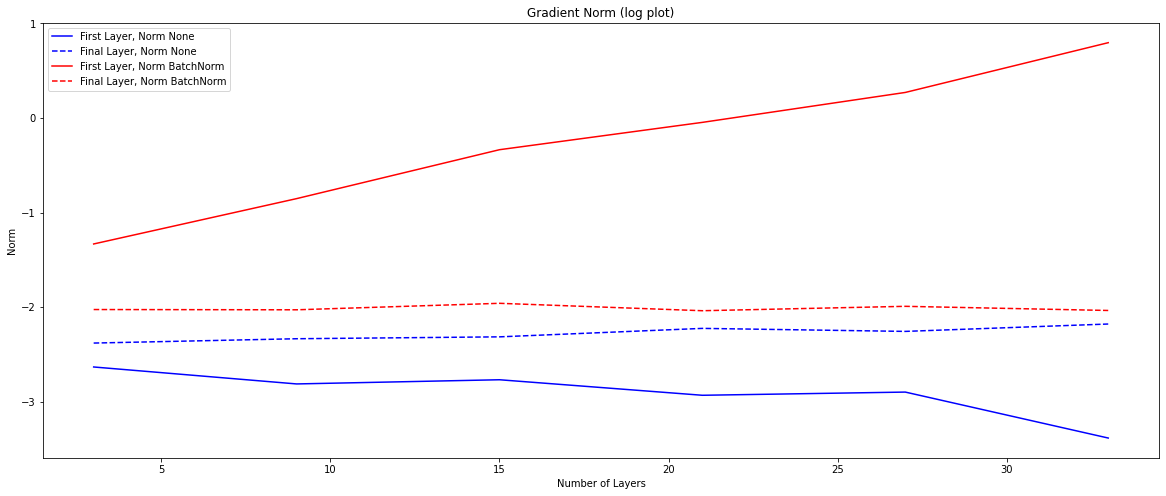

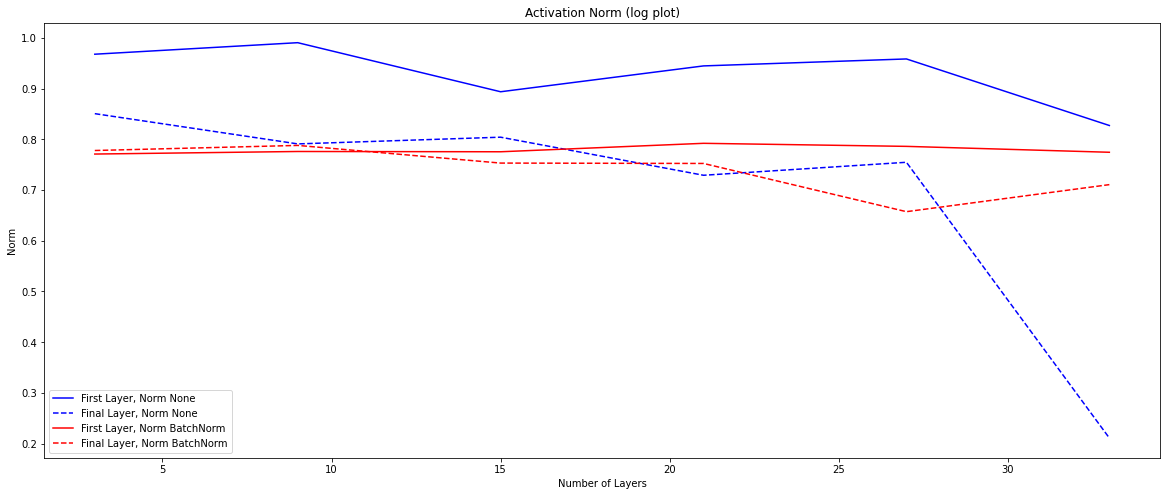

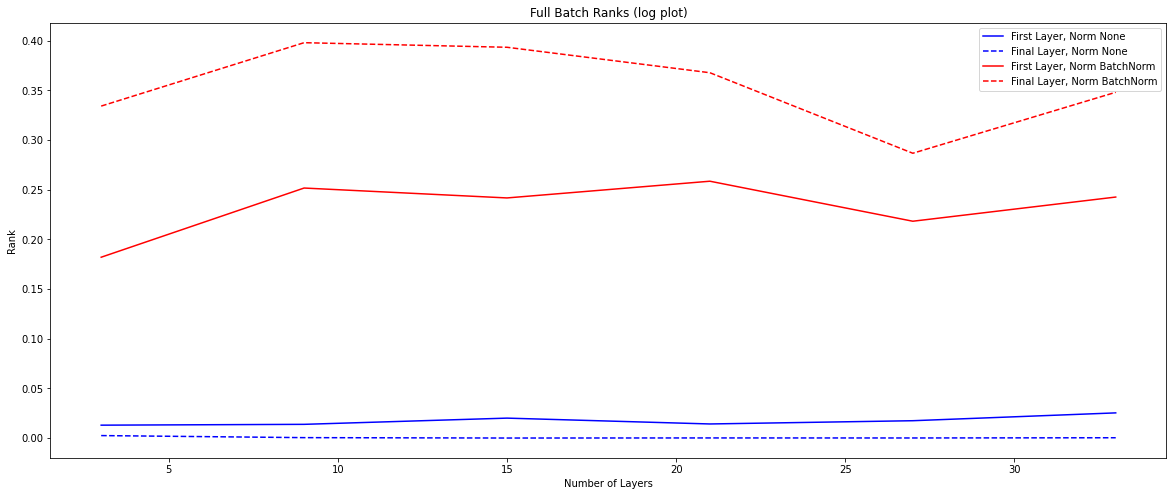

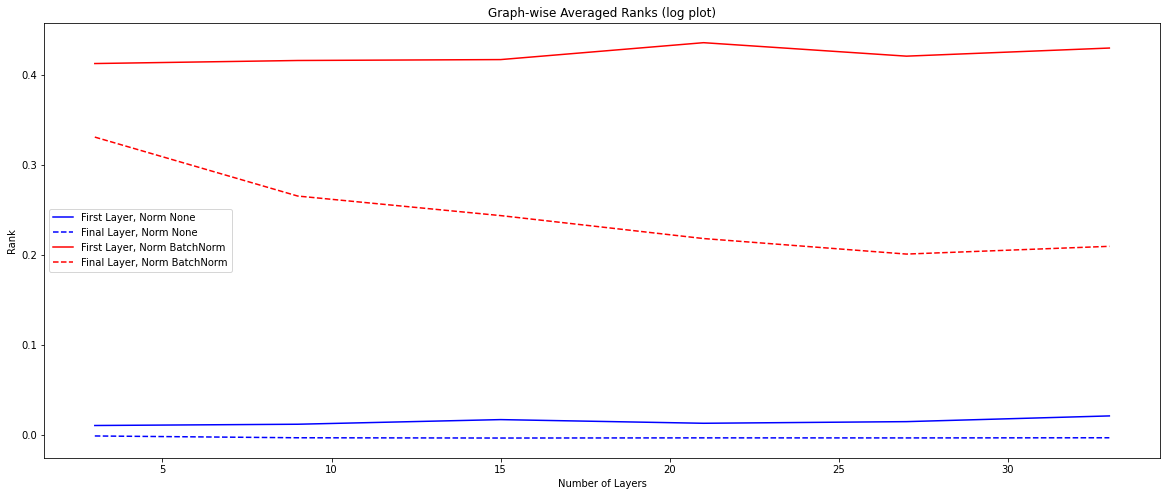

In [65]:
def get_norm_by_layer(order_param, title, ylabel):
    # Plot: 
    # First layer gradient norm vs. depth, for each normalization setting
    # Final layer gradient norm vs. depth, for each normalization setting

    plt.figure(figsize=(20, 8))
    plt.title(title)
    plt.xlabel("Number of Layers")
    plt.ylabel(ylabel)

    names = list(order_param.keys())
    norms = [n.split("_")[0] for n in names]
    norms = [i for n, i in enumerate(norms) if i not in norms[:n]]

    for linestyle, norm in zip(['b', 'r', 'g', 'k'], norms):

        if norm != "DiffGroupNorm":

            Layer1 = []
            LayerF = []

            for depth in depths:

                depth = depth.item()

                Layer1.append(order_param['{}_{}'.format(norm, depth)][0])
                LayerF.append(order_param['{}_{}'.format(norm, depth)][depth-1])

            # slope_1, int_1 = np.polyfit(depths, np.log10(Layer1), 1)
            # slope_F, int_F = np.polyfit(depths, np.log10(LayerF), 1)

            plt.plot(depths, np.log10(Layer1), '{}-'.format(linestyle), label="First Layer, Norm {}".format(norm))
            # plt.plot(depths, slope_1 * depths + int_1, '{}-'.format(linestyle), label="First Layer, Norm {}".format(norm))

            plt.plot(depths, np.log10(LayerF), '{}--'.format(linestyle), label="Final Layer, Norm {}".format(norm))
            # plt.plot(depths, slope_F * depths + int_F, '{}--'.format(linestyle), label="Final Layer, Norm {}".format(norm))


    plt.legend()
    plt.show()

get_norm_by_layer(initial_grads_all, "Gradient Norm (log plot)", "Norm")
get_norm_by_layer(initial_activs_all, "Activation Norm (log plot)", "Norm")
get_norm_by_layer(initial_full_ranks_all, "Full Batch Ranks (log plot)", "Rank")
get_norm_by_layer(initial_graph_mean_ranks_all, "Graph-wise Averaged Ranks (log plot)", "Rank")

In [12]:
print (initial_feature_ranks_all['None_3'])

{0: [tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan)], 1: [tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan)], 2: [tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan

IndexError: ignored

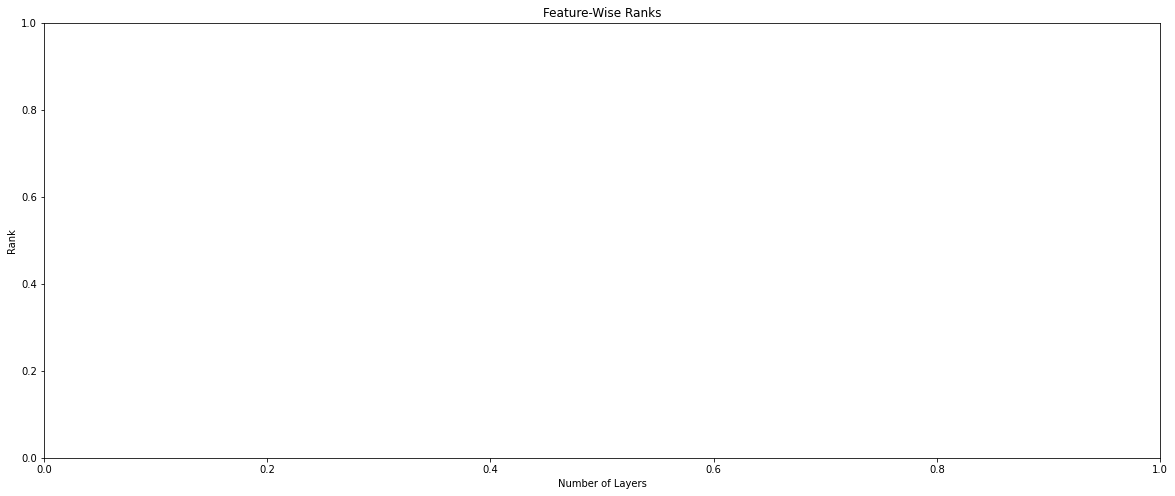

In [11]:
# Plot: 
# First layer gradient norm vs. depth, for each normalization setting
# Final layer gradient norm vs. depth, for each normalization setting

plt.figure(figsize=(20, 8))
plt.title("Feature-Wise Ranks")
plt.xlabel("Number of Layers")
plt.ylabel("Rank")

names = list(initial_feature_ranks_all.keys())
norms = [n.split("_")[0] for n in names]
norms = [i for n, i in enumerate(norms) if i not in norms[:n]]

for linestyle, norm in zip(['b', 'r', 'g', 'k'], norms):

    if norm != "DiffGroupNorm":

        for feat in np.arange(0, 11):

            Layer1 = []
            LayerF = []

            for depth in depths:

                depth = depth.item()

                Layer1.append(initial_feature_ranks_all['{}_{}'.format(norm, depth)][feat][0])
                LayerF.append(initial_feature_ranks_all['{}_{}'.format(norm, depth)][feat][depth-1])

            # slope_1, int_1 = np.polyfit(depths, np.log10(Layer1), 1)
            # slope_F, int_F = np.polyfit(depths, np.log10(LayerF), 1)

            plt.plot(depths, np.log10(Layer1), '{}-'.format(linestyle), label="First Layer, Feature {}, Norm {}".format(feat, norm))
            # plt.plot(depths, slope_1 * depths + int_1, '{}-'.format(linestyle), label="First Layer, Norm {}".format(norm))

            plt.plot(depths, np.log10(LayerF), '{}--'.format(linestyle), label="Final Layer, Feature {}, Norm {}".format(feat, norm))
            # plt.plot(depths, slope_F * depths + int_F, '{}--'.format(linestyle), label="Final Layer, Norm {}".format(norm))


plt.legend()
plt.show()

In [ ]:
# print (list(train_loader)[0])
print (list(train_loader)[0].batch.shape)

M = list(train_loader)[0].x
print (max(list(train_loader)[0].batch))
print (M.shape)
# print (max)

print (int(M.shape[0] / (max(list(train_loader)[0].batch) + 1) ))
D = M.reshape(128, 18, 11)

print (M.tolist())
print (D.tolist())

print (D[:, :, 0])
print (D[:, :, 0].shape)

# for i in range(18):
    # print (M[i, :] == D[0, i, :]) 
    # print (D[0, i, :])


torch.Size([2304])
tensor(127)
torch.Size([2304, 11])
18
[[0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 3.0], [0.0, 0.0, 1.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 2.0], [0.0, 0.0, 0.0, 1.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 2.0], [0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0,

In [ ]:

def train_regression(train_loader, model, criterion, optimizer):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        x = data.x.type(torch.FloatTensor).to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)

        out = model(x, edge_index, batch).flatten() # Perform a single forward pass.
        y = data.y[:, 0].flatten().to(device)

        loss = criterion(out, y)  # Compute the loss.
        loss.backward()  # Derive gradients.

        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test_regression(loader, model, criterion):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        x = data.x.type(torch.FloatTensor).to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)

        y = data.y[:, 0].flatten().to(device)
        out = model(x, edge_index, batch).flatten()

    return criterion(out, y)  # MSE 

epochs = 50
depths = torch.arange(3, 56, 8)

final_train_acc = {}
final_test_acc = {}
activs_train_all = {}
ranks_train_all = {}
grads_train_all = {}

# Training loop
# Iterate over different normalization types
# for norm_setting in [None, 'BatchNorm', 'GraphNorm', 'PairNorm']:
for norm_setting in [None]:

    # Iterate over different model depths
    for depth in tqdm(depths):

        if norm_setting == 'BatchNorm' or norm_setting == 'GraphNorm':
                norm_args = {'in_channels': hidden_channels}
        else:
            norm_args = None

        name = '{}_{}'.format(str(norm_setting), depth)

        # Define model, optimizer, and loss
        model = GCN(
                    hidden_channels=hidden_channels, 
                    num_input_features = dataset[0].x.shape[-1],
                    num_layers=depth, 
                    task=task, 
                    norm=norm_setting, 
                    norm_args=norm_args
        ).to(device)        
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.MSELoss()

        accuracies = {'test_acc': [], 'train_acc': []}

        # Training loop
        for epoch in tqdm(range(1, epochs+1)):
            train_regression(train_loader, model, criterion, optimizer)
            train_acc = test_regression(train_loader, model, criterion)
            test_acc = test_regression(test_loader, model, criterion)
            accuracies['test_acc'].append(test_acc)
            accuracies['train_acc'].append(train_acc)
            print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        final_train_acc[name] = accuracies['train_acc']
        final_test_acc[name] = accuracies['test_acc']

        a, g, r = save_order_params(model)

        activs_train_all[name] = a
        ranks_train_all[name] = r
        grads_train_all[name] = g
    

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Train Acc: 0.0113, Test Acc: 1.5193


KeyboardInterrupt: ignored

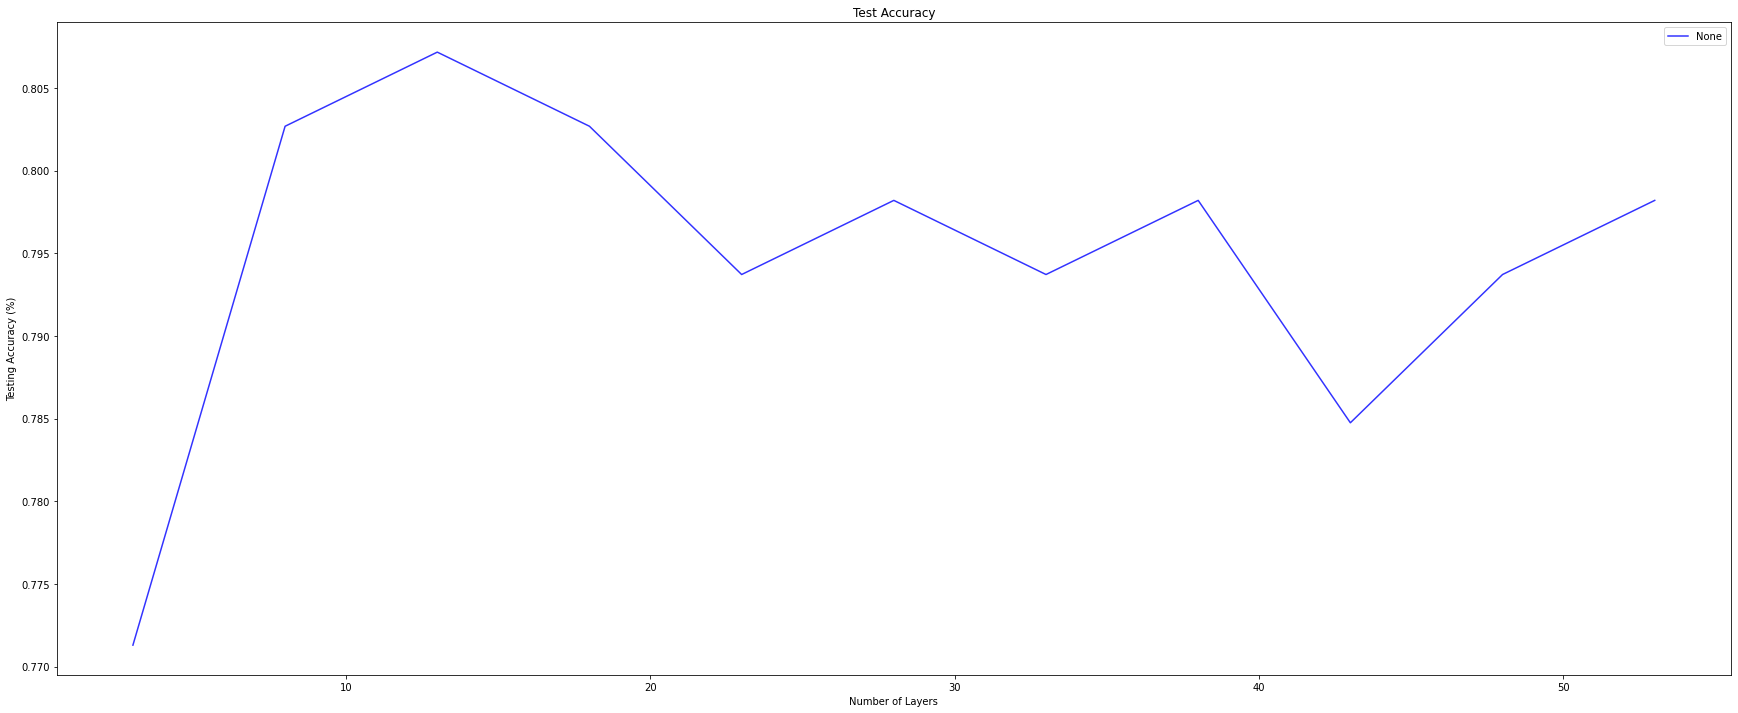

In [ ]:
# print (final_test_acc)

plt.figure(figsize=(30, 12))
plt.title('Test Accuracy')
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy (%)")

names = list(final_test_acc.keys())
norms = [n.split("_")[0] for n in names]
norms = [i for n, i in enumerate(norms) if i not in norms[:n]]

# for linestyle, norm in zip(['b', 'r', 'g', 'k'], norms):
for linestyle, norm in zip(['b'], norms):


    if norm != "DiffGroupNorm":

        Layer1 = []
        LayerF = []

        for depth in depths:

            depth = depth.item()

            Layer1.append(max(final_test_acc['{}_{}'.format(norm, depth)]))
            # LayerF.append(final_test_acc['{}_{}'.format(norm, depth)][depth-1])

        plt.plot(depths, Layer1, '{}-'.format(linestyle), markersize=3, alpha=0.8, label=norm)

        # plt.plot(depths, np.log10(LayerF), '{}s'.format(linestyle), markersize=3, alpha=0.3)


plt.legend()
plt.show()

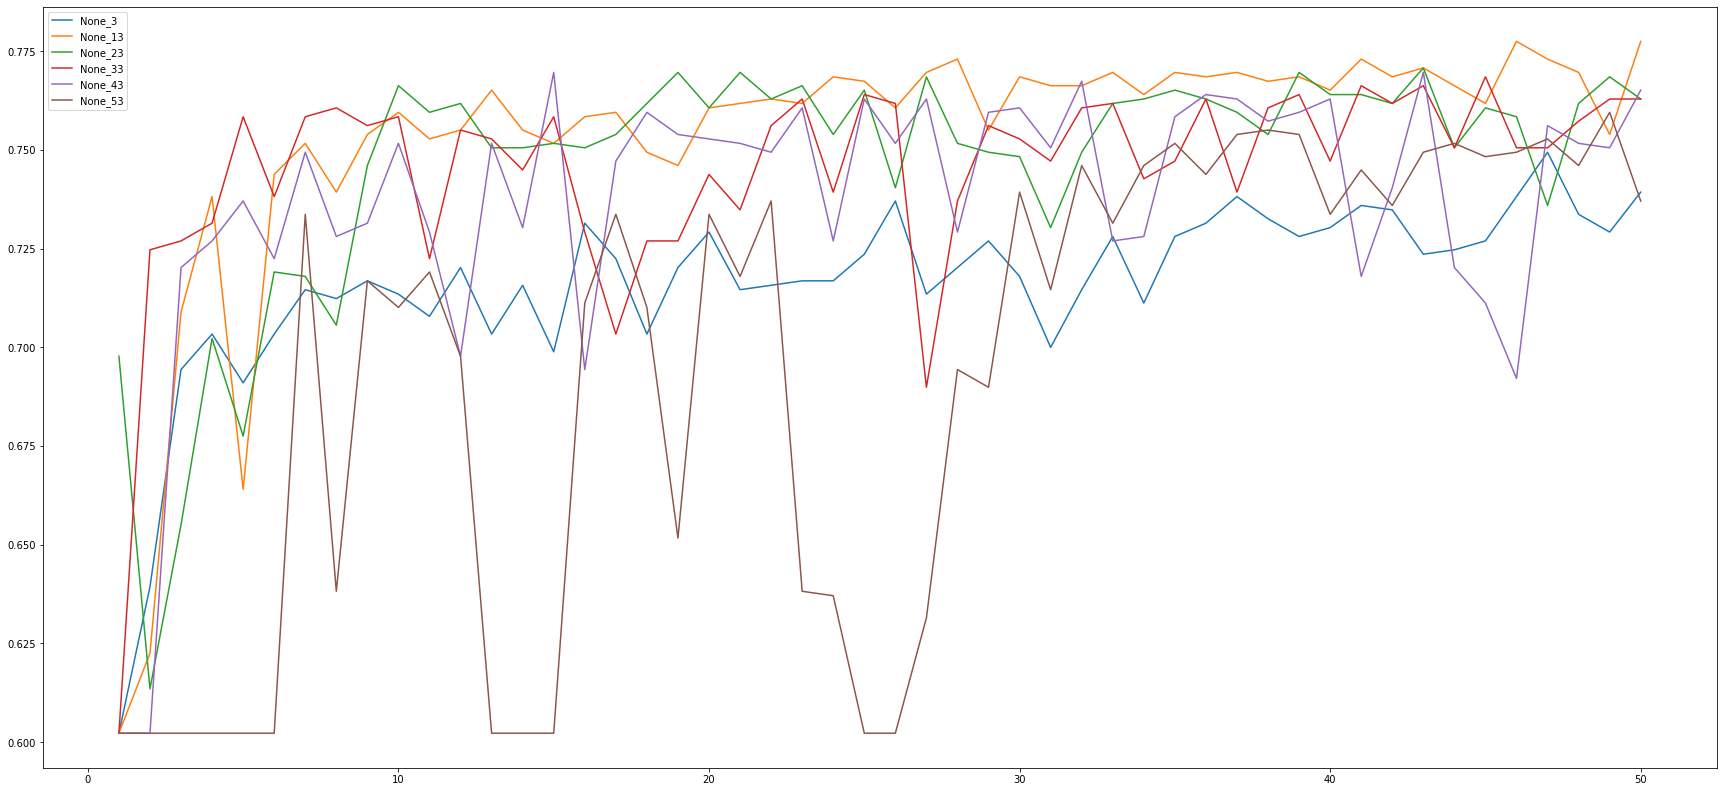

In [ ]:
plt.figure(figsize=(30, 14))
for idx, (k,v) in enumerate(final_train_acc.items()):
    if idx % 2 == 0:
        plt.plot([i for i in range(1, 51)], v, label=k)
plt.legend()
plt.show()

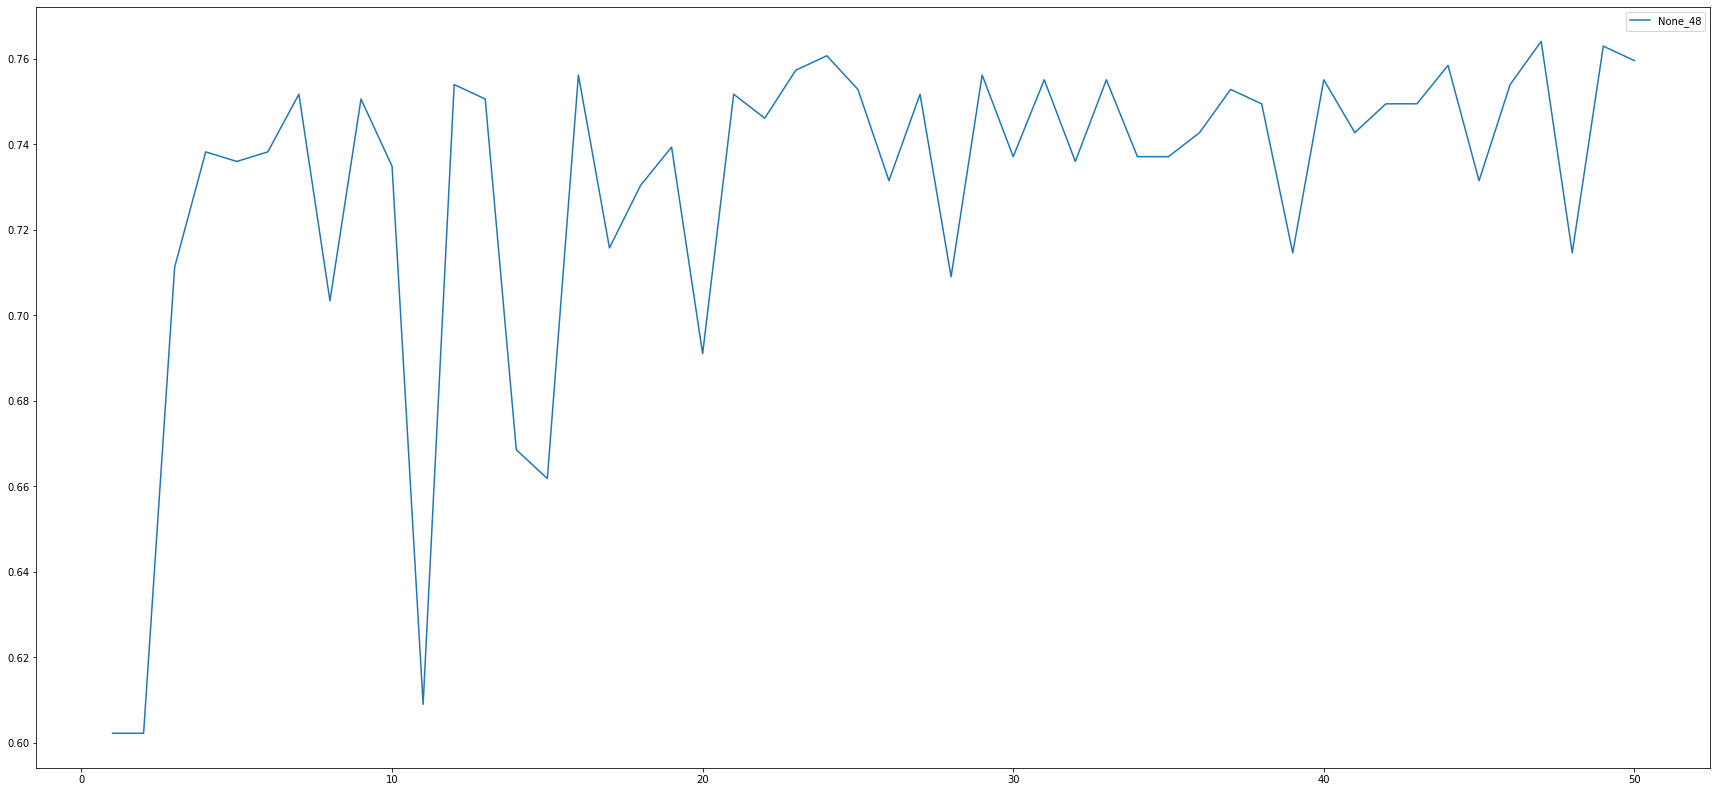

In [ ]:
plt.figure(figsize=(30, 14))
for idx, (k,v) in enumerate(final_train_acc.items()):
    if idx == 9:
        plt.plot([i for i in range(1, 51)], v, label=k)
plt.legend()
plt.show()